In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install trueskill

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import trueskill
import json

f = open('dump.json', 'r')

data = json.load(f)['real_data']
f.close()

del data['Zd6MSPC7S9haRl7Nh0hlqKFr9xN2']

In [3]:
filtered_data_keys = []
for key in data:
  if key != '---' and data[key]['general_data']['effectively_finished'] and \
  data[key]['general_data']['about_the_participant']['gender'] == 'Masculine':
    filtered_data_keys.append(key)
print(len(filtered_data_keys))

58


In [4]:
font_names = [
  'Jenson',
  'Baskerville',
  'Bodoni',
  'Clarendon',
  'Franklin Gothic',
  'Helvetica',
  'Scala Sans',
  'Futura',
  'Comic Neue'
]

In [5]:
matches = []
for p in filtered_data_keys:
  if 'general_data' in data[p] and data[p]['general_data']['effectively_finished']:
    for answer in data[p]['answers']:
      op1 = answer["option0"]["i_font"]
      op2 = answer["option1"]["i_font"]
      if answer["selected_option"]["i_font"] == op1:
        matches.append((op1,op2))
      else:
        matches.append((op2,op1))

In [6]:
font_players = []

for i in range(len(font_names)):
  p = trueskill.Rating()

  print(f"initial rating for {font_names[i]}: {p}")
  font_players.append(p)

initial rating for Jenson: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Baskerville: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Bodoni: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Clarendon: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Franklin Gothic: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Helvetica: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Scala Sans: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Futura: trueskill.Rating(mu=25.000, sigma=8.333)
initial rating for Comic Neue: trueskill.Rating(mu=25.000, sigma=8.333)


In [7]:
for i in range(len(matches)):
  p0_i = matches[i][0]
  p1_i = matches[i][1]
  font_players[p0_i], font_players[p1_i] = trueskill.rate_1vs1(font_players[p0_i], font_players[p1_i])

In [8]:
font_players.sort(key=lambda x: x.mu, reverse=True)


# this is wrong! 
for i in range(len(font_players)):  
  print(f"final rating for ‘{font_names[i]}’: {font_players[i]}")

final rating for ‘Jenson’: trueskill.Rating(mu=26.032, sigma=0.781)
final rating for ‘Baskerville’: trueskill.Rating(mu=25.850, sigma=0.781)
final rating for ‘Bodoni’: trueskill.Rating(mu=25.314, sigma=0.780)
final rating for ‘Clarendon’: trueskill.Rating(mu=25.023, sigma=0.780)
final rating for ‘Franklin Gothic’: trueskill.Rating(mu=25.000, sigma=0.780)
final rating for ‘Helvetica’: trueskill.Rating(mu=24.708, sigma=0.780)
final rating for ‘Scala Sans’: trueskill.Rating(mu=24.264, sigma=0.779)
final rating for ‘Futura’: trueskill.Rating(mu=24.081, sigma=0.781)
final rating for ‘Comic Neue’: trueskill.Rating(mu=24.033, sigma=0.779)


## Let's shuffle

In [9]:
def init_player_rankings(n = len(font_names)):
  temp_rankings = []

  for i in range(n):
    p = trueskill.Rating()
    temp_rankings.append(p)

  return temp_rankings

In [10]:
import random
from statistics import stdev, mean

def shuffle(data, n_players, n_shuffles=150):
  p_list = []
  stdevs = [[],[]]
  
  

  for i in range(n_shuffles):
      random.shuffle(data)
      temp_players = init_player_rankings(n_players)
      for j in range(len(data)):
        p0_i = data[j][0]
        p1_i = data[j][1]
        temp_players[p0_i], temp_players[p1_i] = trueskill.rate_1vs1(temp_players[p0_i], temp_players[p1_i])

      p_list.append(temp_players) 

      if i > 0:
        temp_p = []

        # calculates the std dev of each ranking so far
        for k in range(n_players):
          temp_p.append(stdev([p_list[j][k].mu for j in range(i+1)]))

        stdevs[0].append(i)
        stdevs[1].append(stdev(temp_p))

  return p_list, stdevs


In [11]:
p_list, stdevs = shuffle(matches, len(font_names), 150)

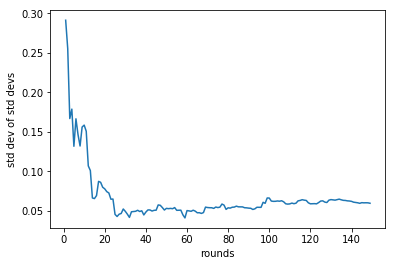

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(stdevs[0],stdevs[1])
plt.ylabel('std dev of std devs')
plt.xlabel('rounds')
plt.show()

In [13]:

from statistics import mean

avg_mus = []
avg_sigmas = []
for i in range(len(font_names)):
  avg_mus.append(mean([p_list[j][i].mu for j in range(len(p_list))]))  
  avg_sigmas.append(mean([p_list[j][i].sigma for j in range(len(p_list))]))
  
print(avg_mus)
print(avg_sigmas)

[25.32583286901716, 25.497719222537217, 25.00181646484285, 25.15716880933993, 25.007448275709187, 24.779436395721476, 24.363033098829238, 25.341256655097258, 25.445047955571376]
[0.780422060546795, 0.7798206533194837, 0.7792191208606667, 0.7795736807068363, 0.7795102894763472, 0.7791932830538107, 0.7806274376340936, 0.7793750040780553, 0.7792246632658366]


In [14]:
rebuilt_ranking = []
for i in range(len(font_names)):
  rebuilt_ranking.append({
      'font': font_names[i],
      'mu': avg_mus[i],
      'sigma': avg_sigmas[i]
    })

rebuilt_ranking.sort(key=lambda x: x['mu'], reverse=True)
for i in range(len(font_names)):
  print(rebuilt_ranking[i])

{'font': 'Baskerville', 'mu': 25.497719222537217, 'sigma': 0.7798206533194837}
{'font': 'Comic Neue', 'mu': 25.445047955571376, 'sigma': 0.7792246632658366}
{'font': 'Futura', 'mu': 25.341256655097258, 'sigma': 0.7793750040780553}
{'font': 'Jenson', 'mu': 25.32583286901716, 'sigma': 0.780422060546795}
{'font': 'Clarendon', 'mu': 25.15716880933993, 'sigma': 0.7795736807068363}
{'font': 'Franklin Gothic', 'mu': 25.007448275709187, 'sigma': 0.7795102894763472}
{'font': 'Bodoni', 'mu': 25.00181646484285, 'sigma': 0.7792191208606667}
{'font': 'Helvetica', 'mu': 24.779436395721476, 'sigma': 0.7791932830538107}
{'font': 'Scala Sans', 'mu': 24.363033098829238, 'sigma': 0.7806274376340936}


In [15]:
path = 'rankings.json'

with open(path, 'w') as outfile:
    json.dump(rebuilt_ranking, outfile)